
### About
#### Generate answers using an LLM from Elastic Search results, and find the cosine similarity between the original answer and the LLM-generated answer.
#### Use the LLM as a judge to compare the relevance of original answers and answers generated by the LLM.
#### Use the LLM as a judge to compare the relevance of LLM-generated answers to questions.

### Import necessary packages and libraries

In [2]:
pip install elasticsearch -qq 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sentence_transformers==2.7.0 -qq

Note: you may need to restart the kernel to use updated packages.


In [145]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import io
import os
import json
import requests
from tqdm.notebook import tqdm
import subprocess
import time
import json
import elasticsearch
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
from IPython.display import clear_output

### Get data

In [9]:
!wget https://raw.githubusercontent.com/hariprasath-v/Nnet101_Assistant/refs/heads/main/data/nnet_101_qna_with_id.json

--2024-10-08 12:08:25--  https://raw.githubusercontent.com/hariprasath-v/Nnet101_Assistant/refs/heads/main/data/nnet_101_qna_with_id.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534194 (522K) [text/plain]
Saving to: 'nnet_101_qna_with_id.json'

nnet_101_qna_with_i 100%[===================>] 521.67K  --.-KB/s    in 0.1s    

2024-10-08 12:08:25 (3.52 MB/s) - 'nnet_101_qna_with_id.json' saved [534194/534194]



### Load data

In [10]:
with open('nnet_101_qna_with_id.json', 'rt') as f_in:
    documents = json.load(f_in)

In [11]:
documents[0]

{'question': 'How to choose the number of hidden layers and nodes in a feedforward neural network?',
 'tags': 'model-selection|neural-networks',
 'answer': "**Network Configuration in Neural Networks**\n\n**Standardization**\nThere is no single standardized method for configuring networks. However, guidelines exist for setting the number and type of network layers, as well as the number of neurons in each layer.\n\n**Initial Architecture Setup**\nBy following specific rules, one can establish a competent network architecture. This involves determining the number and type of neuronal layers and the number of neurons within each layer. This approach provides a foundational architecture but may not be optimal.\n\n**Iterative Tuning**\nOnce the network is initialized, its configuration can be iteratively tuned during training. Ancillary algorithms, such as pruning, can be used to eliminate unnecessary nodes, optimizing the network's size and performance.\n\n**Network Layer Types and Sizing

### Load ground truth data

In [12]:
df_ground_truth_url = 'https://raw.githubusercontent.com/hariprasath-v/Nnet101_Assistant/refs/heads/main/data/ground-truth-data.csv'
df_ground_truth=pd.read_csv(df_ground_truth_url)
df_ground_truth.head()

,question,tags,document
0,How do I choose the number of hidden layers in...,model-selection|neural-networks,f55240b8
1,How many nodes should I use in each hidden layer?,model-selection|neural-networks,f55240b8
2,When should I use pruning to optimize network ...,model-selection|neural-networks,f55240b8
3,What is the relationship between the number of...,model-selection|neural-networks,f55240b8
4,How can I determine the optimal network size f...,model-selection|neural-networks,f55240b8


### Convert to dictionary

In [13]:
ground_truth = df_ground_truth.to_dict(orient='records')

In [14]:
ground_truth[0]

{'question': 'How do I choose the number of hidden layers in a neural network?',
 'tags': 'model-selection|neural-networks',
 'document': 'f55240b8'}

### Collect the document id

In [15]:
doc_idx = {d['id']: d for d in documents}


In [16]:
doc_idx['f55240b8']['answer']

"**Network Configuration in Neural Networks**\n\n**Standardization**\nThere is no single standardized method for configuring networks. However, guidelines exist for setting the number and type of network layers, as well as the number of neurons in each layer.\n\n**Initial Architecture Setup**\nBy following specific rules, one can establish a competent network architecture. This involves determining the number and type of neuronal layers and the number of neurons within each layer. This approach provides a foundational architecture but may not be optimal.\n\n**Iterative Tuning**\nOnce the network is initialized, its configuration can be iteratively tuned during training. Ancillary algorithms, such as pruning, can be used to eliminate unnecessary nodes, optimizing the network's size and performance.\n\n**Network Layer Types and Sizing**\nEvery neural network has input, hidden, and output layers.\n\n* **Input Layer:** Number of neurons is determined by the number of features in the traini

### Get sentence transformer model

In [17]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Elasticsearch setup

In [27]:
es_client = Elasticsearch('http://localhost:9200/', request_timeout=60) 

In [28]:
!curl localhost:9200

{
  "name" : "7ac8f07a9601",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "G_AbQeyUQPKBAfuZEeZvgA",
  "version" : {
    "number" : "8.14.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "8d96bbe3bf5fed931f3119733895458eab75dca9",
    "build_date" : "2024-06-03T10:05:49.073003402Z",
    "build_snapshot" : false,
    "lucene_version" : "9.10.0",
    "minimum_wire_compatibility_version" : "7.17.0",
    "minimum_index_compatibility_version" : "7.0.0"
  },
  "tagline" : "You Know, for Search"
}


### Create index and to elasticsearch

In [29]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "answer": {"type": "text"},
            "question": {"type": "text"},
            "tags": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_answer_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "nnet101"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'nnet101'})

### Combine question and answer, and encode.

In [30]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    answer = doc['answer']
    doc['question_answer_vector'] = model.encode(question + ' ' + answer, show_progress_bar=False)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/500 [00:00<?, ?it/s]

## Retrieval

In [31]:
def elastic_search_knn(field, vector):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        
    }

    search_query = {
        "knn": knn,
        "_source": ["answer", "tags", "question", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs


### Function to embed a question and answer, and return the result based on the question and asnwer vector.

In [32]:
def question_text_vector_knn(q):
    question = q['question']
   

    v_q = model.encode(question, show_progress_bar=False)

    return elastic_search_knn('question_answer_vector', v_q,)

### Sample search

In [33]:
question_text_vector_knn({'question':
    'what is pooling layer?'}
    )

[{'question': 'What is global max pooling layer and what is its advantage over maxpooling layer?',
  'tags': 'neural-networks|convolutional-neural-network|pooling',
  'answer': '**Summary:**\n\nGlobal max pooling is a type of max pooling where the pool size is equal to the input size. Unlike regular max pooling, which produces a smaller output, global max pooling produces an output with the same dimensionality as the input.\n\nIn global max pooling, the maximum value across the entire input is extracted, providing a representation that focuses on the most prominent feature. This is useful in applications like natural language processing, where the most important words in a sentence are often indicative of its meaning.\n\nIn contrast, regular max pooling divides the input into smaller segments and extracts the maximum value from each segment, reducing the output size. This is more common in computer vision, where spatial information is important and reducing the size of the representati

## The RAG flow

In [42]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"tags: {doc['tags']}\nquestion: {doc['question']}\nanswer: {doc['answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

### Cloudflare network Workers AI configuration

In [36]:

ACCOUNT_ID = "acc_id"
AUTH_TOKEN = "token"

prompt = "Tell me all about PEP-8"
response = requests.post(
  f"https://api.cloudflare.com/client/v4/accounts/{ACCOUNT_ID}/ai/run/@cf/meta/llama-2-7b-chat-int8",
    headers={"Authorization": f"Bearer {AUTH_TOKEN}"},
    json={
      "messages": [
        {"role": "user", "content": prompt}
      ]
    }
)
result = response.json()
result

{'result': {'response': 'PEP 8, also known as the Python Enhancement Proposal 8, is a style guide for writing Python code. It was written by Guido van Rossum, the creator of the Python programming language, to provide a set of best practices for writing Python code.\n\nPEP 8 was first published in 2001 and has since become an essential reference for Python developers. The guide covers a range of topics, including:\n\n1. **Indentation**: PEP 8 recommends using 4 spaces for indentation, and discouraged the use of tabs.\n2. **Naming conventions**: It provides guidelines for naming variables, functions, classes, and modules, including the use of underscores to separate words and lowercase letters for variable names.\n3. **Code layout**: It recommends consistent line lengths, consistent indentation, and the use of blank lines to separate logical sections of code.\n4. **Comments**: PEP 8 provides recommendations for commenting code, including the use of docstrings and inline comments.\n5. **

### Workers AI - llama-2-7b-chat-int8 model

In [70]:
def llm(prompt, model='meta/llama-2-7b-chat-int8'):
    response = requests.post(
      f"https://api.cloudflare.com/client/v4/accounts/{ACCOUNT_ID}/ai/run/@cf/{model}",
    headers={"Authorization": f"Bearer {AUTH_TOKEN}"},
    json={
      "messages": [
        {"role": "user", "content": prompt}
      ]
        }
    )
    result = response.json()
    return result

In [69]:
def rag(query,model='meta/llama-2-7b-chat-int8'):
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt,model)
    return answer

In [39]:
ground_truth[10]

{'question': 'What are keys, queries, and values in attention mechanisms?',
 'tags': 'neural-networks|natural-language|attention|machine-translation',
 'document': 'bac0222f'}

### LLM answer

In [64]:
print(rag(ground_truth[10]))

{'result': {'response': "Based on the provided CONTEXT, here's the answer to the QUESTION:\n\nIn attention mechanisms, keys, queries, and values are used as follows:\n\n* The query represents the input to be matched.\n* The keys store the candidate matches.\n* The values store the information associated with each key.\n* The query is matched against the keys to retrieve the relevant values, which are then weighted by a probability vector alpha to produce the final output.\n\nIn other words, the keys, queries, and values are used together to compute attention weights that determine how much information from each key-value pair should be included in the final output."}, 'success': True, 'errors': [], 'messages': []}


### Original answer

In [44]:
doc_idx['bac0222f']['answer']

"In the key/value/query formulation of attention, the query represents the input to be matched, while the keys and values store the candidate matches and their associated information.\nLike a search engine, attention's query is matched against a set of keys, and the best matched values are returned.\nThis retrieval process involves calculating a probability vector alpha, which determines the proportion of each value to include in the output.\n\nThe first paper (Bahdanau et al. 2015) calculates alpha using a neural network, which is computationally expensive.\nThe second paper (Vaswani et al. 2017) proposes a more efficient approach, where the keys and values are first projected onto a common space, and then a similarity measure is used to calculate alpha.\nThis approach corresponds to the retrieval system concept, where the query and key projections are analogous to the user query and video metadata, respectively.\n\nMultihead attention extends this key/value/query formulation by split

### Cosine similarity metric

In [66]:
answer_orig = "In the key/value/query formulation of attention, the query represents the input to be matched, while the keys and values store the candidate matches and their associated information.\nLike a search engine, attention's query is matched against a set of keys, and the best matched values are returned.\nThis retrieval process involves calculating a probability vector alpha, which determines the proportion of each value to include in the output.\n\nThe first paper (Bahdanau et al. 2015) calculates alpha using a neural network, which is computationally expensive.\nThe second paper (Vaswani et al. 2017) proposes a more efficient approach, where the keys and values are first projected onto a common space, and then a similarity measure is used to calculate alpha.\nThis approach corresponds to the retrieval system concept, where the query and key projections are analogous to the user query and video metadata, respectively.\n\nMultihead attention extends this key/value/query formulation by splitting the inputs into multiple heads and applying attention to each head independently.\nThe outputs of each head are then concatenated to produce the final attention output.\n\nThe source of the queries, keys, and values depends on the application.\nFor self-attention (as in language models), they all come from the same source.\nFor tasks like machine translation, queries and keys can come from different sources (e.g., target and source sequences, respectively).\nIn recommendation systems, queries can represent target items, while keys and values can represent user profiles and history."


In [67]:
answer_llm = """Based on the provided CONTEXT, here's the answer to the QUESTION:\n\nIn attention mechanisms, keys, queries, and values are used as follows:\n\n* The query represents the input to be matched.\n* The keys store the candidate matches.\n* The values store the information associated with each key.\n* The query is matched against the keys to retrieve the relevant values, which are then weighted by a probability vector alpha to produce the final output.\n\nIn other words, the keys, queries, and values are used together to compute attention weights that determine how much information from each key-value pair should be included in the final output"""


v_llm = model.encode(answer_llm, show_progress_bar=False)
v_orig = model.encode(answer_orig,show_progress_bar=False)



### Sample similarity score

In [68]:
v_llm.dot(v_orig)

0.748703

### Generate answer for ground truth data

In [103]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def process_record(i, rec, doc_idx):
    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['answer']
    
    return i, {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'tags': rec['tags'],
    }

# Dictionary to store results
answers = {}

# ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_record, i, rec, doc_idx)
        for i, rec in enumerate(ground_truth) if i not in answers
    ]

    # Collect results as they complete
    for future in tqdm(as_completed(futures), total=len(futures)):
        i, result = future.result()
        answers[i] = result


100%|██████████| 2500/2500 [16:34<00:00,  2.51it/s]


### Create dataframe

In [106]:
results_llama_2_7b_chat_int8 = [None] * len(ground_truth)

for i, val in answers.items():
    results_llama_2_7b_chat_int8[i] = val.copy()
    results_llama_2_7b_chat_int8[i].update(ground_truth[i])

In [108]:
results_llama_2_7b_chat_int8_df = pd.DataFrame(results_llama_2_7b_chat_int8)

In [123]:
results_llama_2_7b_chat_int8_df['answer_llm'] = results_llama_2_7b_chat_int8_df['answer_llm'].apply(lambda x:x['result']['response'])

### Compute similarity score for the entire document

In [52]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm , show_progress_bar=False)
    v_orig = model.encode(answer_orig, show_progress_bar=False)
    
    return v_llm.dot(v_orig)

In [53]:
similarity = []

for record in tqdm(results_llama_2_7b_chat_int8_df.to_dict(orient='records')):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [55]:
results_llama_2_7b_chat_int8_df['cosine'] = similarity
results_llama_2_7b_chat_int8_df['cosine'].describe()

count    2500.000000
mean        0.675582
std         0.161148
min        -0.020848
25%         0.582057
50%         0.705028
75%         0.792661
max         0.981918
Name: cosine, dtype: float64

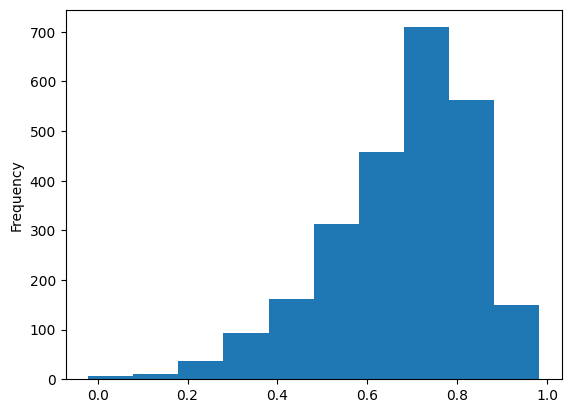

In [61]:
pd.Series(similarity).plot(kind='hist');

### Save dataframe

In [80]:
results_llama_2_7b_chat_int8_df.to_csv("llm_answers_llama_2_7b_chat_int8.csv",index=False)

## Workers AI - mistral-7b-instruct-v0.1

In [78]:
def process_record(i, rec, doc_idx):
    answer_llm = rag(rec,model="/mistral/mistral-7b-instruct-v0.1")
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['answer']
    
    return i, {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'tags': rec['tags'],
    }

# Dictionary to store results
answers_new = {}

# ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_record, i, rec, doc_idx)
        for i, rec in enumerate(ground_truth) if i not in answers_new
    ]

    # Collect results as they complete
    for future in tqdm(as_completed(futures), total=len(futures)):
        i, result = future.result()
        answers_new[i] = result


100%|██████████| 2500/2500 [1:01:26<00:00,  1.47s/it]


### Create dataframe

In [81]:
mistral_7b_instruct_v0_1 = [None] * len(ground_truth)

for i, val in answers_new.items():
    mistral_7b_instruct_v0_1[i] = val.copy()
    mistral_7b_instruct_v0_1[i].update(ground_truth[i])

In [82]:
mistral_7b_instruct_v0_1_df = pd.DataFrame(mistral_7b_instruct_v0_1)

In [86]:
 mistral_7b_instruct_v0_1_df['answer_llm'] = mistral_7b_instruct_v0_1_df['answer_llm'].apply(lambda x: x['result']['response'])

### Calculate similarity

In [87]:
similarity_new = []

for record in tqdm(mistral_7b_instruct_v0_1_df.to_dict(orient='records')):
    sim = compute_similarity(record)
    similarity_new.append(sim)

100%|██████████| 2500/2500 [04:27<00:00,  9.35it/s]


In [88]:
mistral_7b_instruct_v0_1_df['cosine'] = similarity_new
mistral_7b_instruct_v0_1_df['cosine'].describe()

count    2500.000000
mean        0.709169
std         0.157913
min        -0.068219
25%         0.621302
50%         0.741953
75%         0.825930
max         0.986987
Name: cosine, dtype: float64

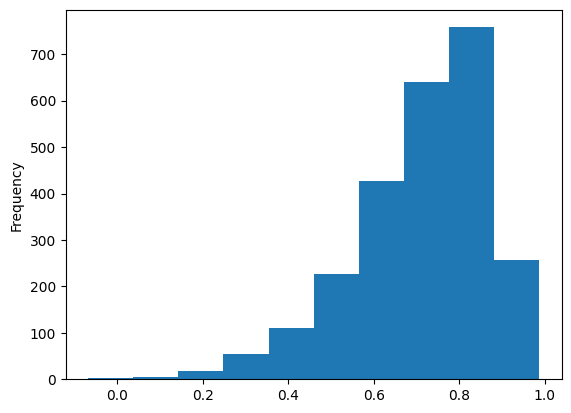

In [89]:
pd.Series(similarity_new).plot(kind='hist');

In [90]:
mistral_7b_instruct_v0_1_df.to_csv("llm_answers_mistral_7b_instruct_v0_1.csv",index=False)

### LLM-as-a-Judge

In [97]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

### Llma Evaluation

In [92]:
df_sample_llama = results_llama_2_7b_chat_int8_df.sample(n=150, random_state=1)

In [93]:
df_sample_llama = df_sample_llama.to_dict(orient='records')

In [95]:
record = df_sample_llama[0]
record

{'answer_llm': 'According to the context, SNNs (Spiking Neural Networks) are not mentioned in the provided context. However, the question asks how SNNs differ from previous neural network models. Since SNNs are not mentioned, we cannot provide a direct answer. \n\nIf the question was rephrased to ask about the differences between previous neural network models, the answer would be that the context mentions various types of neural networks, including:\n\n1. Perceptrons: A specific type of neural network introduced by Rosenblatt in 1957.\n2. Multi-Layered Perceptron (MLP): A type of feed-forward neural network with layers of fully connected nodes.\n3. Recurrent Neural Networks (RNNs): Neural networks with undirected loops within layers, providing storage capacity.\n4. Hopfield Network: A type of neural network with a single interconnected layer and binary nodes.\n5. Restricted Boltzmann Machines (RBMs): Two-layer models with visible and hidden units.\n6. Convolutional Neural Networks (CN

In [98]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: **Summary:**

Understanding neural networks, including their structure and function, remains a significant challenge. The field has progressed through three key models:

* **Perceptron Model:** Can compute any boolean function using a multilayer perceptron with a hidden layer.
* **Neuron Model:** An improved version using sigmoid activation, capable of computing any boolean function and approximating continuous functions.
* **Spiking Neurons Model:** Incorporates temporal coding to pass information, allowing for more efficient computation than the previous models and a closer fidelity to the human 

In [105]:
answer = llm(prompt, model='meta/llama-2-7b-chat-int8')

In [114]:
evaluations_llama = []

for record in tqdm(df_sample_llama):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='meta/llama-2-7b-chat-int8')
    evaluations_llama.append(evaluation)

100%|██████████| 150/150 [09:55<00:00,  3.97s/it]


In [157]:
def process_eval_results(evaluations):
    res = []
    for i, str_eval in enumerate(evaluations):
        match = re.findall(r'"Relevance":\s*"([^"]+)"',str_eval['result']['response'])[0]
        res.append(match)
    return res

In [159]:
df_evaluations_llama = pd.DataFrame(process_eval_results(evaluations_llama))

In [163]:
df_evaluations_llama.value_counts()

0              
RELEVANT           85
PARTLY_RELEVANT    54
NON_RELEVANT       11
Name: count, dtype: int64

In [185]:
evaluations_llama_2 = []

for record in tqdm(df_sample_llama):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='meta/llama-2-7b-chat-int8')
    evaluations_llama_2.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [187]:
df_evaluations_llama_2 = pd.DataFrame(process_eval_results(evaluations_llama_2))

In [188]:
df_evaluations_llama_2.value_counts()

0              
RELEVANT           74
PARTLY_RELEVANT    70
NON_RELEVANT        6
Name: count, dtype: int64

In [189]:
df_evaluations_llama.to_csv('evaluations_llama-aqa.csv', index=False)
df_evaluations_llama_2.to_csv('evaluations_llama-qa.csv', index=False)